In [1]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
import time
from keras.models import Sequential
from keras.layers import InputLayer, Input , Conv2D, Dense, Flatten , Reshape , MaxPool2D , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras

3.3.1


C:\Users\hafiz\Anaconda3\envs\flow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from data_utils import load_tl_extracts
from random_mini_batch import random_mini_batches

setting demintion of each image to 64 * 64

In [3]:
desired_dim = (64,64)
data_dirs = ['data']
test_data = ['test']

## Importing Data

In [4]:
x_train, y_train = load_tl_extracts(data_dirs, desired_dim)
x_test,y_test = load_tl_extracts(test_data, desired_dim)
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)

x train shape:  (12503, 64, 64, 3)
y train shape:  (12503,)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486,)


In [5]:
def show_histogram(y):
    y_set = set(y)
    y_dict = {y: i for i,y in enumerate(y_set)}
    y_n = [y_dict[el] for el in y]
    n_classes = len(y_set)
    
    #distribution of examples per class
    plt.hist(y_n, bins=n_classes);
    plt.xlabel('Class');
    plt.ylabel('Number of samples');
    print(y_dict)

{'green': 0, 'off': 13, 'greenstraightleft': 1, 'greenleft': 2, 'greenright': 12, 'redright': 3, 'background': 4, 'yellow': 6, 'redstraightleft': 8, 'red': 9, 'redleft': 10, 'greenstraightright': 11, 'redstraight': 5, 'greenstraight': 7}


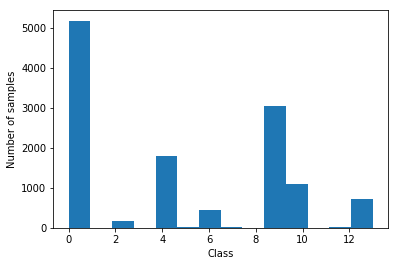

In [6]:
show_histogram(y_train)

In [7]:
#keep only green,red,yellow,off,background
relevant = ['green','off','yellow','red','background']
x_train = x_train[np.isin(y_train, relevant)]
y_train = y_train[np.isin(y_train, relevant)]

{'off': 0, 'red': 1, 'green': 2, 'background': 3, 'yellow': 4}


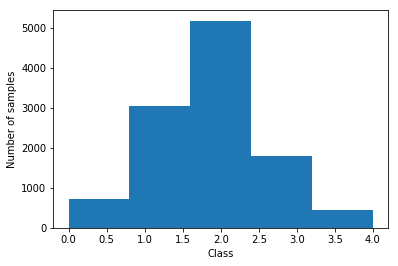

In [8]:
show_histogram(y_train)

{'off': 0, 'red': 1, 'green': 2, 'yellow': 3}


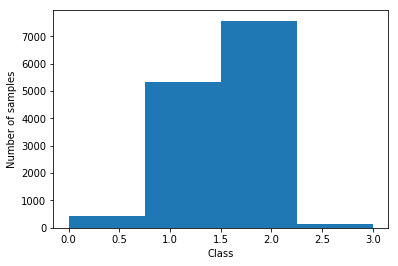

In [9]:
show_histogram(y_test)

In [10]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

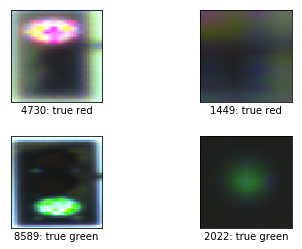

In [11]:
rows = 2
cols = 2
cls = None
show_images(x_train, y_train, rows, cols, cls)

In [12]:
print('After keeping Only 5 Classes: ')
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.reshape((11189,1)).shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.reshape((13486,1)).shape)

After keeping Only 5 Classes: 
x train shape:  (11189, 64, 64, 3)
y train shape:  (11189, 1)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486, 1)


## Splitting the train set into train set and validation set

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.33, random_state=42)

#### Covering each image to a column vector

In [14]:
print('x train shape: ',x_train.shape)
print('x validation shape: ',x_validation.shape)
print('x test shape: ',x_test.shape)

x train shape:  (7496, 64, 64, 3)
x validation shape:  (3693, 64, 64, 3)
x test shape:  (13486, 64, 64, 3)


### Normalize image vectors

In [15]:
x_train = x_train/255.
x_validation = x_validation/255.
x_test = x_test/255.

In [16]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [17]:
print('True class of first 5 image',y_train[0:5])

True class of first 5 image ['red' 'green' 'off' 'green' 'background']


In [18]:
#setting each class to a integer
data = {}
data['red'] = 0
data['green'] = 1
data['off'] = 2
data['yellow'] = 3
data['background'] = 4

def string_to_int(b):
    y = b
    k = y.shape[0]

    for j in range(0,k):
        if (y[j]=='0' or y[j]=='1' or y[j]=='2' or y[j]=='3' or y[j]=='4'):
            y[j] = y[j]
        else:
            y[j] = data[y[j]]

    y = y.astype(np.int)
    return y


#### one hot matrix convertion

In [19]:
y_train = one_hot_matrix(string_to_int(y_train),C=5)
y_validation = one_hot_matrix(string_to_int(y_validation),C=5)
y_test = one_hot_matrix(string_to_int(y_test),C=5)

print('y train shape: ',y_train.shape)
print('y validation shape: ',y_validation.shape)
print('x test shape: ',y_test.shape)

y train shape:  (5, 7496)
y validation shape:  (5, 3693)
x test shape:  (5, 13486)


In [20]:
y_train = y_train.T
y_validation = y_validation.T
y_test = y_test.T
print('y train shape: ',y_train.shape)
print('y validation shape: ',y_validation.shape)
print('x test shape: ',y_test.shape)

y train shape:  (7496, 5)
y validation shape:  (3693, 5)
x test shape:  (13486, 5)


In [21]:
print('One hot martrix of first 5 elements:')
print(y_train[:,0:5])
y_tain_true_class = np.array([label.argmax() for label in y_train])
y_validation_true_class = np.array([label.argmax() for label in y_validation])
y_test_true_class = np.array([label.argmax() for label in y_test])
print('True Classes of first 5 elements:')
print(y_tain_true_class[0:5])

One hot martrix of first 5 elements:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
True Classes of first 5 elements:
[0 1 2 1 4]


In [22]:
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x validation shape: ',x_validation.shape)
print('y validation shape: ',y_validation.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)

x train shape:  (7496, 64, 64, 3)
y train shape:  (7496, 5)
x validation shape:  (3693, 64, 64, 3)
y validation shape:  (3693, 5)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486, 5)


### Model

In [23]:
def classifier_model():
    from keras.layers import Activation, Convolution2D, Dropout, Conv2D
    from keras.layers import AveragePooling2D, BatchNormalization
    from keras.layers import GlobalAveragePooling2D
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import MaxPooling2D
    from keras.layers import SeparableConv2D
    from keras import layers
    from keras.regularizers import l2
    
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                                name='image_array', input_shape=(64,64,3)))
    model.add(BatchNormalization())

    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

    model.add(Dropout(.5))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=5, kernel_size=(3, 3), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    
    return model

### Model Summery

In [24]:
batch_size = 32
num_epochs = 1000
do_random_crop = True
patience = 10
num_classes = 5
input_shape = (64, 64, 3)

from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

# model parameters/compilation
model = classifier_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 64, 64, 16)        2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        12560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
__________

### Train

In [25]:
# model callbacks
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/2), verbose=1)

model_checkpoint = ModelCheckpoint('weight_tl.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False)
callbacks = [model_checkpoint, early_stop, reduce_lr]

# training model
hist = model.fit_generator(image_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(x_train.shape[0] / batch_size),
                    epochs=num_epochs, verbose=1,
                    callbacks=callbacks,
                    validation_data=(x_validation, y_validation))


Epoch 1/1000
234/234 [==============================] - 15s 66ms/step - loss: 0.4036 - acc: 0.8634 - val_loss: 0.4475 - val_acc: 0.8662

Epoch 00001: val_loss improved from inf to 0.44750, saving model to weight_tl.h5
Epoch 2/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.2945 - acc: 0.8993 - val_loss: 0.2289 - val_acc: 0.9266

Epoch 00002: val_loss improved from 0.44750 to 0.22886, saving model to weight_tl.h5
Epoch 3/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.2653 - acc: 0.9107 - val_loss: 0.4078 - val_acc: 0.8800

Epoch 00003: val_loss did not improve from 0.22886
Epoch 4/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.2389 - acc: 0.9187 - val_loss: 0.2334 - val_acc: 0.9247

Epoch 00004: val_loss did not improve from 0.22886
Epoch 5/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.2268 - acc: 0.9196 - val_loss: 0.1750 - val_acc: 0.9448

Epoch 00005: val_loss improved from 0.22886 to 

234/234 [==============================] - 13s 54ms/step - loss: 0.1441 - acc: 0.9459 - val_loss: 0.1204 - val_acc: 0.9605

Epoch 00040: val_loss did not improve from 0.12012
Epoch 41/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.1381 - acc: 0.9503 - val_loss: 0.1201 - val_acc: 0.9621

Epoch 00041: val_loss improved from 0.12012 to 0.12009, saving model to weight_tl.h5
Epoch 42/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.1414 - acc: 0.9471 - val_loss: 0.1208 - val_acc: 0.9607

Epoch 00042: val_loss did not improve from 0.12009

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 43/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.1399 - acc: 0.9502 - val_loss: 0.1205 - val_acc: 0.9605 5s -

Epoch 00043: val_loss did not improve from 0.12009
Epoch 44/1000
234/234 [==============================] - 13s 54ms/step - loss: 0.1416 - acc: 0.9526 - val_loss: 0.1204 - val_acc: 0.9607


In [26]:
model.load_weights("weight_tl.h5")

In [27]:
final_loss, final_acc = model.evaluate(x_validation, y_validation, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1201, final accuracy: 0.9621


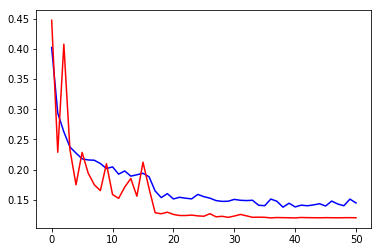

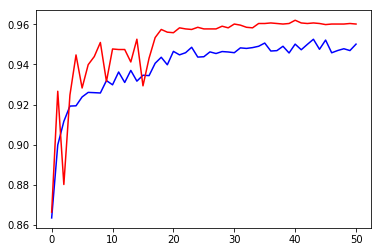

In [28]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

### Predicting Classes

In [29]:
import time
st = time.time()
y_train_pred = model.predict(x=x_train)
y_train_pred = np.argmax(y_train_pred,axis=1)
y_val_pred = model.predict(x=x_validation)
y_val_pred = np.argmax(y_val_pred,axis=1)
y_test_pred = model.predict(x=x_test)
y_test_pred = np.argmax(y_test_pred,axis=1)
en = time.time()
t = en - st

### Evaluating Result

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4']

print("train accuricy: %f" % accuracy_score(y_tain_true_class, y_train_pred))
print("validation accuricy: %f" % accuracy_score(y_validation_true_class, y_val_pred))

train accuricy: 0.958511
validation accuricy: 0.962090


In [31]:
print(classification_report(y_validation_true_class, y_val_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.94      0.97      0.96      1011
    class 1       0.98      0.99      0.99      1705
    class 2       0.88      0.82      0.85       240
    class 3       0.85      0.60      0.71       139
    class 4       0.99      1.00      0.99       598

avg / total       0.96      0.96      0.96      3693



In [32]:
print("test accuricy: %f" % accuracy_score(y_test_true_class, y_test_pred))

test accuricy: 0.976420


In [33]:
print(classification_report(y_test_true_class, y_test_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.98      1.00      0.99      5321
    class 1       0.99      0.99      0.99      7569
    class 2       0.76      0.45      0.56       442
    class 3       0.74      1.00      0.85       154
    class 4       0.00      0.00      0.00         0

avg / total       0.98      0.98      0.97     13486



C:\Users\hafiz\Anaconda3\envs\flow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Calculating Single image processing time

In [34]:
total_images = y_train.shape[1] + y_validation.shape[1] + y_test.shape[1]
print("Single image prediction time: %s ms" % (((t)/total_images)*1000))

Single image prediction time: 943.8135147094727 ms


In [35]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

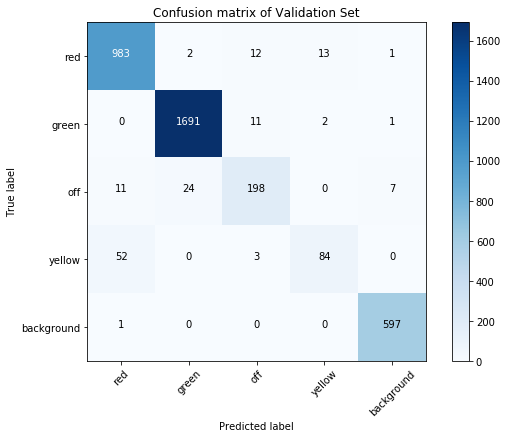

In [36]:
cnf_matrix = confusion_matrix(y_validation_true_class,y_val_pred)
class_names =  ['red','green','off','yellow','background']
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Validation Set')

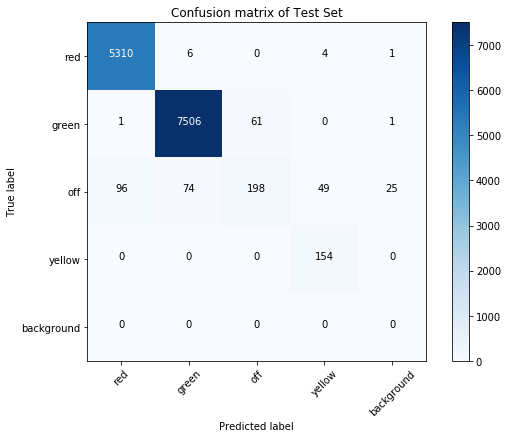

In [37]:
cnf_matrix = confusion_matrix(y_test_true_class,y_test_pred)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Test Set')